# Random Forest Classification on Mushroom Dataset

This notebook implements a comprehensive Random Forest machine learning model to classify mushrooms as edible or poisonous based on their physical characteristics.

## Dataset Information
- **Source**: UCI Machine Learning Repository - Mushroom Dataset
- **Instances**: 8,124 mushroom samples
- **Features**: 22 categorical attributes describing physical characteristics
- **Target**: Binary classification (edible vs poisonous)
- **Class Distribution**: 
  - Edible: 4,208 (51.8%)
  - Poisonous: 3,916 (48.2%)

## Objective
Build a Random Forest classifier to accurately predict mushroom edibility and analyze feature importance to understand which characteristics are most indicative of mushroom safety.


In [24]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Data Loading and Exploration


In [25]:
# Define column names based on the dataset documentation
column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
    'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
    'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color',
    'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'
]

# Load the dataset
data_path = '../datasets/mushroom/agaricus-lepiota.data'
df = pd.read_csv(data_path, header=None, names=column_names)

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
df.head()


Dataset loaded successfully!
Shape: (8124, 23)
Memory usage: 10583.54 KB


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [26]:
# Basic dataset information
print("=== Dataset Information ===")
print(f"Number of instances: {len(df)}")
print(f"Number of features: {len(df.columns) - 1}")  # excluding target column
print(f"Target variable: {df.columns[0]}")
print()

print("=== Data Types ===")
print(df.dtypes)
print()

print("=== Class Distribution ===")
class_counts = df['class'].value_counts()
print(class_counts)
print(f"Class balance: {class_counts.values[0]/len(df)*100:.1f}% vs {class_counts.values[1]/len(df)*100:.1f}%")
print()

print("=== Missing Values ===")
missing_values = df.isnull().sum()
print(f"Total missing values: {missing_values.sum()}")
if missing_values.sum() > 0:
    print("Columns with missing values:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values found")
print()

print("=== Unique Values per Feature ===")
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if col != 'class':  # Don't show all unique values for target
        unique_vals = df[col].unique()
        if len(unique_vals) <= 10:  # Only show if reasonable number
            print(f"  Values: {sorted(unique_vals)}")
    print()


=== Dataset Information ===
Number of instances: 8124
Number of features: 22
Target variable: class

=== Data Types ===
class                       object
cap-shape                   object
cap-surface                 object
cap-color                   object
bruises                     object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
dtype: object

=== Class Distribution ===
class
e    4208
p    3916
Name: c

In [27]:
# Check for missing values represented as '?' 
print("=== Checking for '?' Missing Values ===")
question_marks = (df == '?').sum()
print(f"Features with '?' values:")
for col, count in question_marks.items():
    if count > 0:
        print(f"{col}: {count} missing values ({count/len(df)*100:.1f}%)")

# Identify the feature with missing values
if question_marks.sum() > 0:
    missing_feature = question_marks[question_marks > 0].index[0]
    print(f"\nMissing values found in: {missing_feature}")
    print(f"Unique values in {missing_feature}: {sorted(df[missing_feature].unique())}")
else:
    print("No '?' missing values found")


=== Checking for '?' Missing Values ===
Features with '?' values:
stalk-root: 2480 missing values (30.5%)

Missing values found in: stalk-root
Unique values in stalk-root: ['?', 'b', 'c', 'e', 'r']


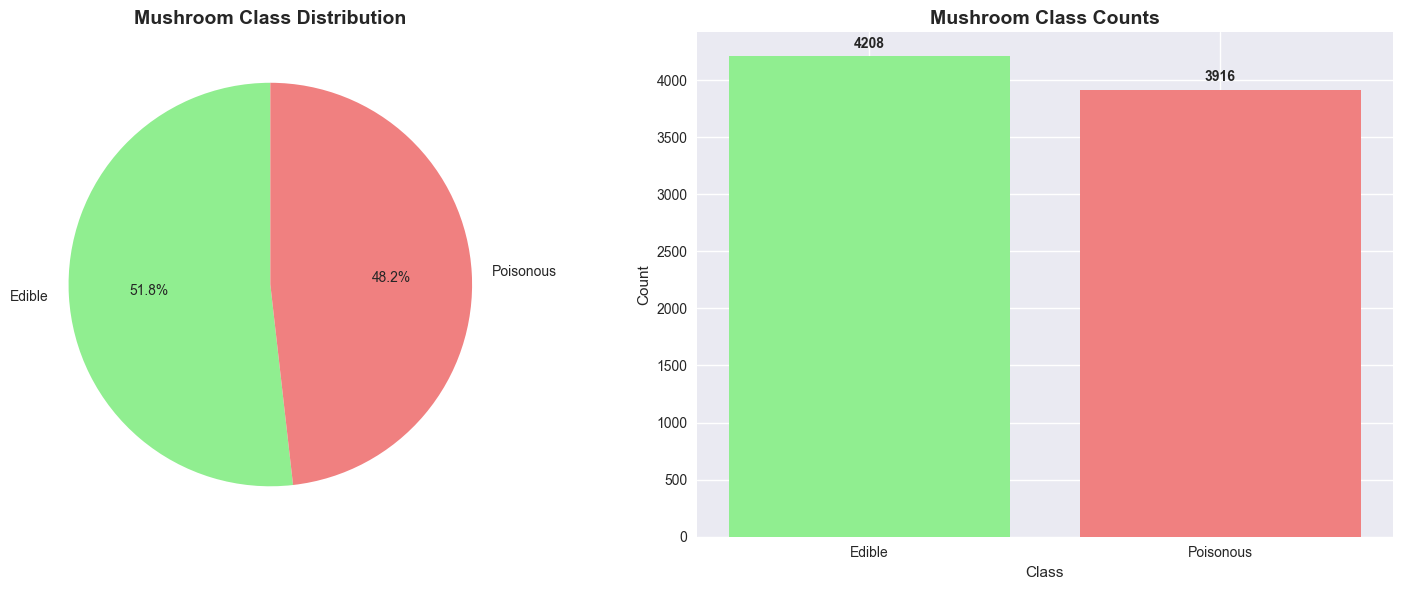

The dataset is relatively balanced:
- Edible mushrooms: 4208 (51.8%)
- Poisonous mushrooms: 3916 (48.2%)


In [28]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Class distribution pie chart
class_counts = df['class'].value_counts()
axes[0].pie(class_counts.values, labels=['Edible', 'Poisonous'], autopct='%1.1f%%', 
           colors=['lightgreen', 'lightcoral'], startangle=90)
axes[0].set_title('Mushroom Class Distribution', fontsize=14, fontweight='bold')

# Class distribution bar chart
class_counts_named = df['class'].map({'e': 'Edible', 'p': 'Poisonous'}).value_counts()
bars = axes[1].bar(class_counts_named.index, class_counts_named.values, 
                   color=['lightgreen', 'lightcoral'])
axes[1].set_title('Mushroom Class Counts', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Class')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"The dataset is relatively balanced:")
print(f"- Edible mushrooms: {class_counts['e']} ({class_counts['e']/len(df)*100:.1f}%)")
print(f"- Poisonous mushrooms: {class_counts['p']} ({class_counts['p']/len(df)*100:.1f}%)")


## 2. Data Preprocessing and Feature Engineering


In [29]:
# Handle missing values in stalk-root feature
print("=== Handling Missing Values ===")
print(f"Missing values in 'stalk-root': {(df['stalk-root'] == '?').sum()}")

# Check the distribution of stalk-root values (excluding missing)
stalk_root_dist = df[df['stalk-root'] != '?']['stalk-root'].value_counts()
print(f"Distribution of stalk-root values (excluding missing):")
print(stalk_root_dist)
print()

# Strategy: Replace missing values with the most frequent value (mode imputation)
mode_value = df[df['stalk-root'] != '?']['stalk-root'].mode()[0]
print(f"Most frequent stalk-root value: '{mode_value}'")

# Replace missing values
df['stalk-root'] = df['stalk-root'].replace('?', mode_value)
print(f"Missing values after imputation: {(df['stalk-root'] == '?').sum()}")
print()


=== Handling Missing Values ===
Missing values in 'stalk-root': 2480
Distribution of stalk-root values (excluding missing):
stalk-root
b    3776
e    1120
c     556
r     192
Name: count, dtype: int64

Most frequent stalk-root value: 'b'
Missing values after imputation: 0



In [30]:
# Check for features with only one unique value (these won't be useful for classification)
print("=== Feature Variance Analysis ===")
single_value_features = []
for col in df.columns:
    if col != 'class':  # Skip target variable
        unique_vals = df[col].nunique()
        if unique_vals == 1:
            single_value_features.append(col)
            print(f"Feature '{col}' has only one unique value: {df[col].iloc[0]}")

if single_value_features:
    print(f"\nFound {len(single_value_features)} feature(s) with single values:")
    print(single_value_features)
    print("These features will be removed as they provide no discriminative information.")
    
    # Remove single-value features
    df_processed = df.drop(columns=single_value_features)
else:
    print("All features have multiple unique values - good for classification!")
    df_processed = df.copy()

print(f"\nDataset shape after removing single-value features: {df_processed.shape}")
print(f"Features removed: {len(df.columns) - len(df_processed.columns)}")


=== Feature Variance Analysis ===
Feature 'veil-type' has only one unique value: p

Found 1 feature(s) with single values:
['veil-type']
These features will be removed as they provide no discriminative information.

Dataset shape after removing single-value features: (8124, 22)
Features removed: 1


In [31]:
# Encode categorical variables using Label Encoding
print("=== Label Encoding ===")
print("Converting categorical features to numerical values...")

# Create a copy for encoding
df_encoded = df_processed.copy()

# Initialize label encoders dictionary
label_encoders = {}

# Encode all categorical features (including target)
for column in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le
    
    # Display encoding mapping for target variable
    if column == 'class':
        print(f"\nTarget encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")
        print(f"  'e' (edible) -> {le.transform(['e'])[0]}")
        print(f"  'p' (poisonous) -> {le.transform(['p'])[0]}")

print(f"\nAll features have been encoded successfully!")
print(f"Dataset shape: {df_encoded.shape}")
print(f"Data types after encoding:")
print(df_encoded.dtypes.value_counts())

# Display first few rows of encoded data
print(f"\nFirst 5 rows of encoded dataset:")
df_encoded.head()


=== Label Encoding ===
Converting categorical features to numerical values...

Target encoding: {'e': np.int64(0), 'p': np.int64(1)}
  'e' (edible) -> 0
  'p' (poisonous) -> 1

All features have been encoded successfully!
Dataset shape: (8124, 22)
Data types after encoding:
int64    22
Name: count, dtype: int64

First 5 rows of encoded dataset:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,2,7,7,2,1,0,3,0,1


In [32]:
# Prepare features and target variables
print("=== Preparing Features and Target ===")

# Separate features and target
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {list(X.columns)}")
print(f"\nTarget distribution:")
print(f"Class 0 (edible): {(y == 0).sum()}")
print(f"Class 1 (poisonous): {(y == 1).sum()}")

# Display feature statistics
print(f"\nFeature statistics:")
print(X.describe())


=== Preparing Features and Target ===
Features shape: (8124, 21)
Target shape: (8124,)
Feature names: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

Target distribution:
Class 0 (edible): 4208
Class 1 (poisonous): 3916

Feature statistics:
         cap-shape  cap-surface    cap-color      bruises         odor  \
count  8124.000000  8124.000000  8124.000000  8124.000000  8124.000000   
mean      3.348104     1.827671     4.504677     0.415559     4.144756   
std       1.604329     1.229873     2.545821     0.492848     2.103729   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       2.000000     0.000000     3.000000     0.000000     2.000000   
50%       3.00

## 3. Train-Test Split


In [33]:
# Split the data into training and testing sets
print("=== Train-Test Split ===")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 80% train, 20% test
    random_state=42,    # For reproducibility
    stratify=y          # Maintain class distribution in both sets
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training set percentage: {X_train.shape[0] / len(X) * 100:.1f}%")
print(f"Test set percentage: {X_test.shape[0] / len(X) * 100:.1f}%")

print(f"\nClass distribution in training set:")
train_class_dist = y_train.value_counts()
print(f"Class 0 (edible): {train_class_dist[0]} ({train_class_dist[0]/len(y_train)*100:.1f}%)")
print(f"Class 1 (poisonous): {train_class_dist[1]} ({train_class_dist[1]/len(y_train)*100:.1f}%)")

print(f"\nClass distribution in test set:")
test_class_dist = y_test.value_counts()
print(f"Class 0 (edible): {test_class_dist[0]} ({test_class_dist[0]/len(y_test)*100:.1f}%)")
print(f"Class 1 (poisonous): {test_class_dist[1]} ({test_class_dist[1]/len(y_test)*100:.1f}%)")

print(f"\nFeature matrix shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


=== Train-Test Split ===
Training set size: 6499 samples
Test set size: 1625 samples
Training set percentage: 80.0%
Test set percentage: 20.0%

Class distribution in training set:
Class 0 (edible): 3366 (51.8%)
Class 1 (poisonous): 3133 (48.2%)

Class distribution in test set:
Class 0 (edible): 842 (51.8%)
Class 1 (poisonous): 783 (48.2%)

Feature matrix shapes:
X_train: (6499, 21)
X_test: (1625, 21)
y_train: (6499,)
y_test: (1625,)


## 4. Random Forest Model Building and Training


In [34]:
# Initialize and train the Random Forest model
print("=== Random Forest Model Training ===")

# Initialize Random Forest with reasonable default parameters
rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees in the forest
    max_depth=None,         # Trees can grow to full depth
    min_samples_split=2,    # Minimum samples required to split an internal node
    min_samples_leaf=1,     # Minimum samples required to be at a leaf node
    max_features='sqrt',    # Number of features to consider for the best split
    bootstrap=True,         # Whether bootstrap samples are used when building trees
    random_state=42,        # For reproducibility
    n_jobs=-1,             # Use all available cores
    class_weight=None       # No class weighting (dataset is balanced)
)

print("Model parameters:")
print(rf_model.get_params())
print()

# Train the model
print("Training the Random Forest model...")
import time
start_time = time.time()

rf_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")
print(f"Number of trees in the forest: {rf_model.n_estimators}")
print(f"Number of features used: {rf_model.n_features_in_}")
print(f"Feature names: {list(X.columns[:5])}...") # Show first 5 feature names


=== Random Forest Model Training ===
Model parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Training the Random Forest model...
Training completed in 0.12 seconds
Number of trees in the forest: 100
Number of features used: 21
Feature names: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor']...


In [35]:
# Make predictions on both training and test sets
print("=== Making Predictions ===")

# Training set predictions
y_train_pred = rf_model.predict(X_train)
y_train_pred_proba = rf_model.predict_proba(X_train)

# Test set predictions
y_test_pred = rf_model.predict(X_test)
y_test_pred_proba = rf_model.predict_proba(X_test)

print(f"Training predictions shape: {y_train_pred.shape}")
print(f"Test predictions shape: {y_test_pred.shape}")
print(f"Training prediction probabilities shape: {y_train_pred_proba.shape}")
print(f"Test prediction probabilities shape: {y_test_pred_proba.shape}")

# Display sample predictions
print(f"\nFirst 10 test predictions vs actual:")
for i in range(10):
    actual = "Edible" if y_test.iloc[i] == 0 else "Poisonous"
    predicted = "Edible" if y_test_pred[i] == 0 else "Poisonous"
    confidence = max(y_test_pred_proba[i]) * 100
    print(f"Sample {i+1}: Actual={actual}, Predicted={predicted}, Confidence={confidence:.1f}%")


=== Making Predictions ===
Training predictions shape: (6499,)
Test predictions shape: (1625,)
Training prediction probabilities shape: (6499, 2)
Test prediction probabilities shape: (1625, 2)

First 10 test predictions vs actual:
Sample 1: Actual=Poisonous, Predicted=Poisonous, Confidence=100.0%
Sample 2: Actual=Poisonous, Predicted=Poisonous, Confidence=100.0%
Sample 3: Actual=Edible, Predicted=Edible, Confidence=100.0%
Sample 4: Actual=Poisonous, Predicted=Poisonous, Confidence=100.0%
Sample 5: Actual=Poisonous, Predicted=Poisonous, Confidence=100.0%
Sample 6: Actual=Edible, Predicted=Edible, Confidence=100.0%
Sample 7: Actual=Edible, Predicted=Edible, Confidence=100.0%
Sample 8: Actual=Edible, Predicted=Edible, Confidence=100.0%
Sample 9: Actual=Edible, Predicted=Edible, Confidence=100.0%
Sample 10: Actual=Poisonous, Predicted=Poisonous, Confidence=100.0%


## 5. Model Evaluation and Performance Metrics


In [36]:
# Calculate comprehensive performance metrics
print("=== Model Performance Metrics ===")

# Training set metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_pred_proba[:, 1])

# Test set metrics  
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba[:, 1])

print("TRAINING SET PERFORMANCE:")
print(f"Accuracy:  {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-Score:  {train_f1:.4f}")
print(f"AUC-ROC:   {train_auc:.4f}")
print()

print("TEST SET PERFORMANCE:")
print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"AUC-ROC:   {test_auc:.4f}")
print()

# Check for overfitting
accuracy_diff = train_accuracy - test_accuracy
print(f"OVERFITTING CHECK:")
print(f"Training-Test Accuracy Difference: {accuracy_diff:.4f} ({accuracy_diff*100:.2f}%)")
if accuracy_diff > 0.05:
    print("WARNING: Model may be overfitting (>5% difference)")
elif accuracy_diff > 0.02:
    print("WARNING: Slight overfitting detected (2-5% difference)")
else:
    print("GOOD: No significant overfitting detected (<2% difference)")


=== Model Performance Metrics ===
TRAINING SET PERFORMANCE:
Accuracy:  1.0000 (100.00%)
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
AUC-ROC:   1.0000

TEST SET PERFORMANCE:
Accuracy:  1.0000 (100.00%)
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
AUC-ROC:   1.0000

OVERFITTING CHECK:
Training-Test Accuracy Difference: 0.0000 (0.00%)
GOOD: No significant overfitting detected (<2% difference)


In [37]:
# Detailed classification report
print("=== Detailed Classification Report ===")
print("\nTRAINING SET:")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Edible', 'Poisonous'], 
                          digits=4))

print("\nTEST SET:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Edible', 'Poisonous'], 
                          digits=4))


=== Detailed Classification Report ===

TRAINING SET:
              precision    recall  f1-score   support

      Edible     1.0000    1.0000    1.0000      3366
   Poisonous     1.0000    1.0000    1.0000      3133

    accuracy                         1.0000      6499
   macro avg     1.0000    1.0000    1.0000      6499
weighted avg     1.0000    1.0000    1.0000      6499


TEST SET:
              precision    recall  f1-score   support

      Edible     1.0000    1.0000    1.0000       842
   Poisonous     1.0000    1.0000    1.0000       783

    accuracy                         1.0000      1625
   macro avg     1.0000    1.0000    1.0000      1625
weighted avg     1.0000    1.0000    1.0000      1625



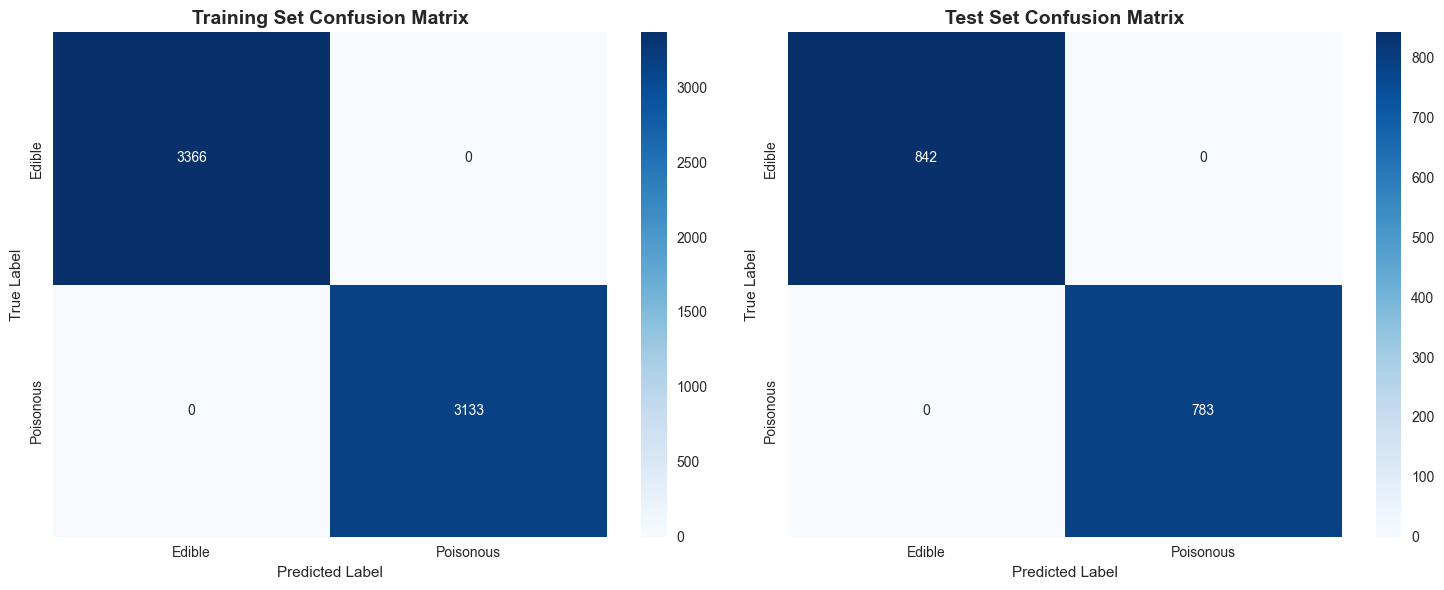

=== Confusion Matrix Interpretation ===
Test Set Results:
True Negatives (Correctly predicted Edible): 842
False Positives (Wrongly predicted Poisonous): 0
False Negatives (Wrongly predicted Edible): 0
True Positives (Correctly predicted Poisonous): 783

Critical Safety Metric:
False Negatives (Poisonous predicted as Edible): 0
This is the most dangerous error in mushroom classification!


In [38]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set confusion matrix
train_cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Edible', 'Poisonous'], 
           yticklabels=['Edible', 'Poisonous'], ax=axes[0])
axes[0].set_title('Training Set Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Test set confusion matrix
test_cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Edible', 'Poisonous'], 
           yticklabels=['Edible', 'Poisonous'], ax=axes[1])
axes[1].set_title('Test Set Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Print confusion matrix interpretation
print("=== Confusion Matrix Interpretation ===")
print("Test Set Results:")
tn, fp, fn, tp = test_cm.ravel()
print(f"True Negatives (Correctly predicted Edible): {tn}")
print(f"False Positives (Wrongly predicted Poisonous): {fp}")
print(f"False Negatives (Wrongly predicted Edible): {fn}")
print(f"True Positives (Correctly predicted Poisonous): {tp}")
print()
print(f"Critical Safety Metric:")
print(f"False Negatives (Poisonous predicted as Edible): {fn}")
print(f"This is the most dangerous error in mushroom classification!")


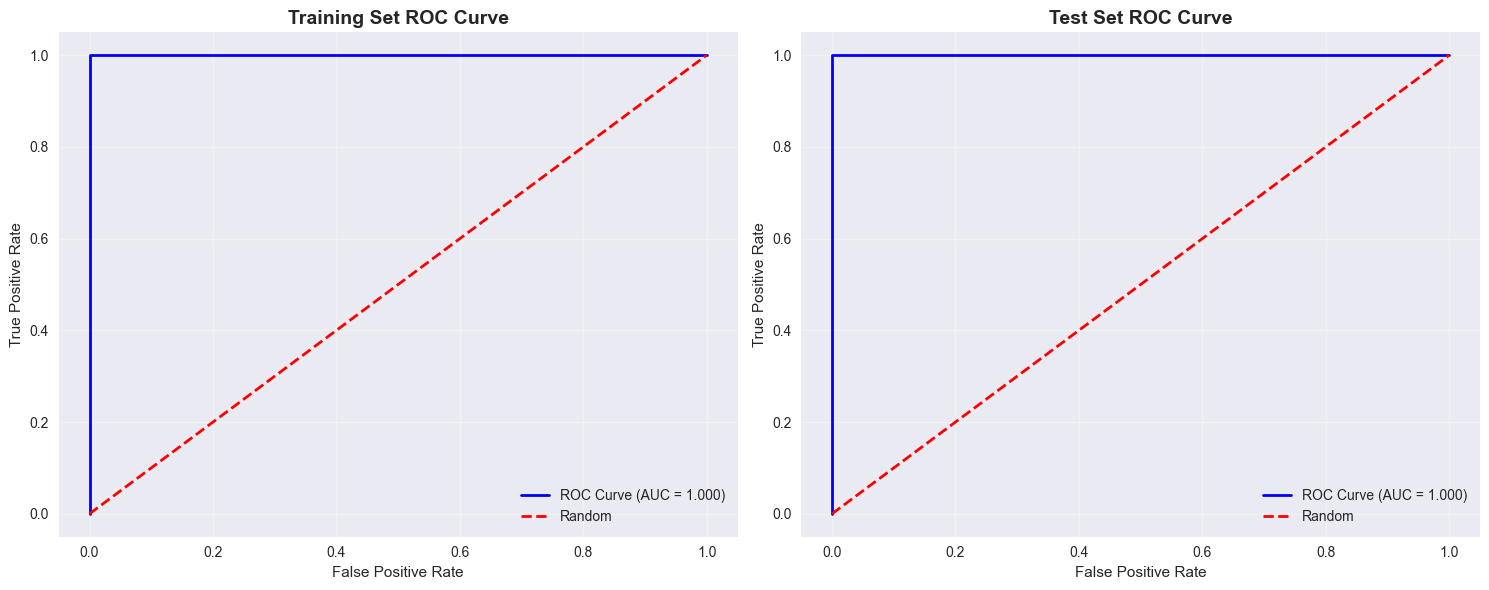

=== ROC-AUC Interpretation ===
Training AUC: 1.0000
Test AUC: 1.0000

 Excellent model performance (AUC ≥ 0.95)


In [39]:
# ROC Curve Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba[:, 1])
axes[0].plot(fpr_train, tpr_train, color='blue', lw=2, 
            label=f'ROC Curve (AUC = {train_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Training Set ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba[:, 1])
axes[1].plot(fpr_test, tpr_test, color='blue', lw=2, 
            label=f'ROC Curve (AUC = {test_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Test Set ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== ROC-AUC Interpretation ===")
print(f"Training AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print()
if test_auc >= 0.95:
    print(" Excellent model performance (AUC ≥ 0.95)")
elif test_auc >= 0.90:
    print(" Very good model performance (AUC ≥ 0.90)")
elif test_auc >= 0.80:
    print(" Good model performance (AUC ≥ 0.80)")
elif test_auc >= 0.70:
    print("  Fair model performance (AUC ≥ 0.70)")
else:
    print("Poor model performance (AUC < 0.70)")


## 6. Feature Importance Analysis


In [40]:
# Extract and analyze feature importance
print("=== Feature Importance Analysis ===")

# Get feature importance from the trained model
feature_importance = rf_model.feature_importances_
feature_names = X.columns

# Create a dataframe for easier manipulation
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))
print()

print("Bottom 5 Least Important Features:")
print(importance_df.tail(5).to_string(index=False))
print()

# Calculate cumulative importance
importance_df['cumulative_importance'] = importance_df['importance'].cumsum()

# Find features that contribute to 80% of total importance
features_80_percent = importance_df[importance_df['cumulative_importance'] <= 0.8]
print(f"Number of features contributing to 80% of importance: {len(features_80_percent)}")
print(f"These features are: {', '.join(features_80_percent['feature'].tolist())}")


=== Feature Importance Analysis ===
Top 10 Most Important Features:
                 feature  importance
                    odor    0.191924
              gill-color    0.132903
               gill-size    0.121674
       spore-print-color    0.101185
               ring-type    0.070925
              population    0.053458
                 bruises    0.053343
              stalk-root    0.044789
stalk-surface-above-ring    0.039434
            gill-spacing    0.037188

Bottom 5 Least Important Features:
        feature  importance
    ring-number    0.012914
    cap-surface    0.009994
      cap-shape    0.004878
     veil-color    0.002028
gill-attachment    0.001393

Number of features contributing to 80% of importance: 8
These features are: odor, gill-color, gill-size, spore-print-color, ring-type, population, bruises, stalk-root


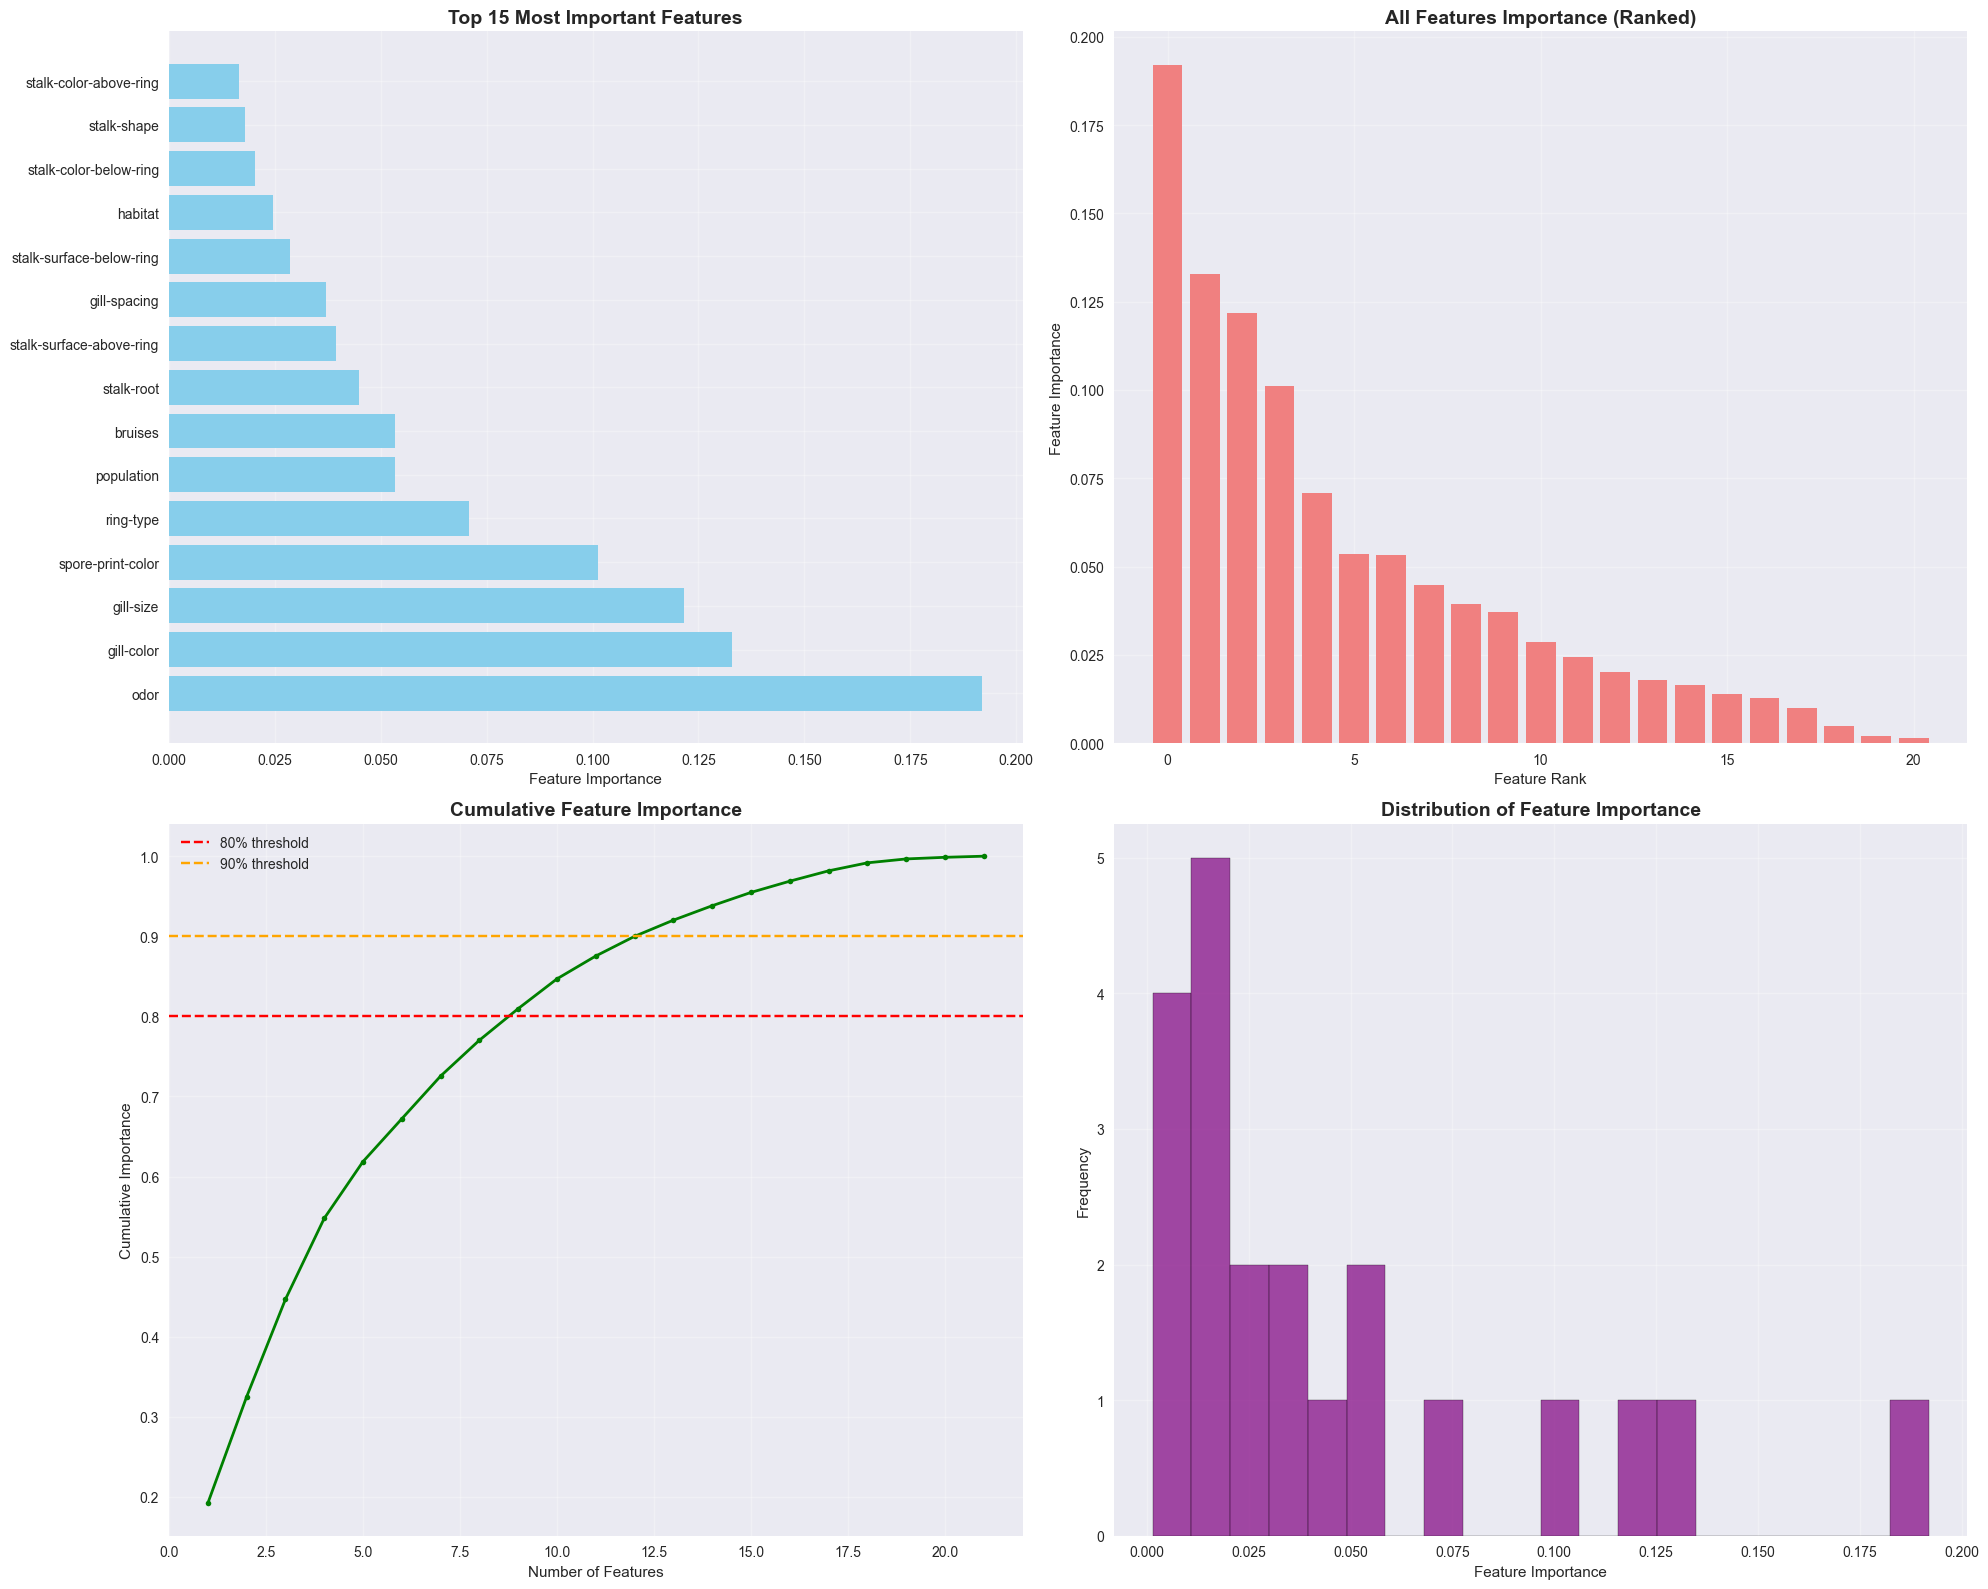

=== Feature Importance Statistics ===
Total number of features: 21
Mean importance: 0.0476
Standard deviation: 0.0503
Maximum importance: 0.1919 (odor)
Minimum importance: 0.0014 (gill-attachment)
Features needed for 50.0% of total importance: 3
Features needed for 80.0% of total importance: 8
Features needed for 90.0% of total importance: 12
Features needed for 95.0% of total importance: 14


In [41]:
# Visualize feature importance
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Top 15 features bar plot
top_features = importance_df.head(15)
axes[0, 0].barh(range(len(top_features)), top_features['importance'], color='skyblue')
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features['feature'])
axes[0, 0].set_xlabel('Feature Importance')
axes[0, 0].set_title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. All features importance (sorted)
axes[0, 1].bar(range(len(importance_df)), importance_df['importance'], color='lightcoral')
axes[0, 1].set_xlabel('Feature Rank')
axes[0, 1].set_ylabel('Feature Importance')
axes[0, 1].set_title('All Features Importance (Ranked)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Cumulative importance plot
axes[1, 0].plot(range(1, len(importance_df) + 1), importance_df['cumulative_importance'], 
               marker='o', linewidth=2, markersize=4, color='green')
axes[1, 0].axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
axes[1, 0].axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
axes[1, 0].set_xlabel('Number of Features')
axes[1, 0].set_ylabel('Cumulative Importance')
axes[1, 0].set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature importance distribution
axes[1, 1].hist(importance_df['importance'], bins=20, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Feature Importance')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Feature Importance', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("=== Feature Importance Statistics ===")
print(f"Total number of features: {len(importance_df)}")
print(f"Mean importance: {importance_df['importance'].mean():.4f}")
print(f"Standard deviation: {importance_df['importance'].std():.4f}")
print(f"Maximum importance: {importance_df['importance'].max():.4f} ({importance_df.iloc[0]['feature']})")
print(f"Minimum importance: {importance_df['importance'].min():.4f} ({importance_df.iloc[-1]['feature']})")

# Find how many features needed for different thresholds
for threshold in [0.5, 0.8, 0.9, 0.95]:
    n_features = len(importance_df[importance_df['cumulative_importance'] <= threshold])
    print(f"Features needed for {threshold*100}% of total importance: {n_features}")


## 7. Cross-Validation and Model Robustness


=== Cross-Validation Analysis ===
5-Fold Cross-Validation Results:
Individual fold scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0000 (±0.0000)
Standard Deviation: 0.0000
Min Score: 1.0000
Max Score: 1.0000

Cross-Validation Results for Multiple Metrics:
ACCURACY: 1.0000 (±0.0000)
PRECISION: 1.0000 (±0.0000)
RECALL: 1.0000 (±0.0000)
F1: 1.0000 (±0.0000)
ROC_AUC: 1.0000 (±0.0000)


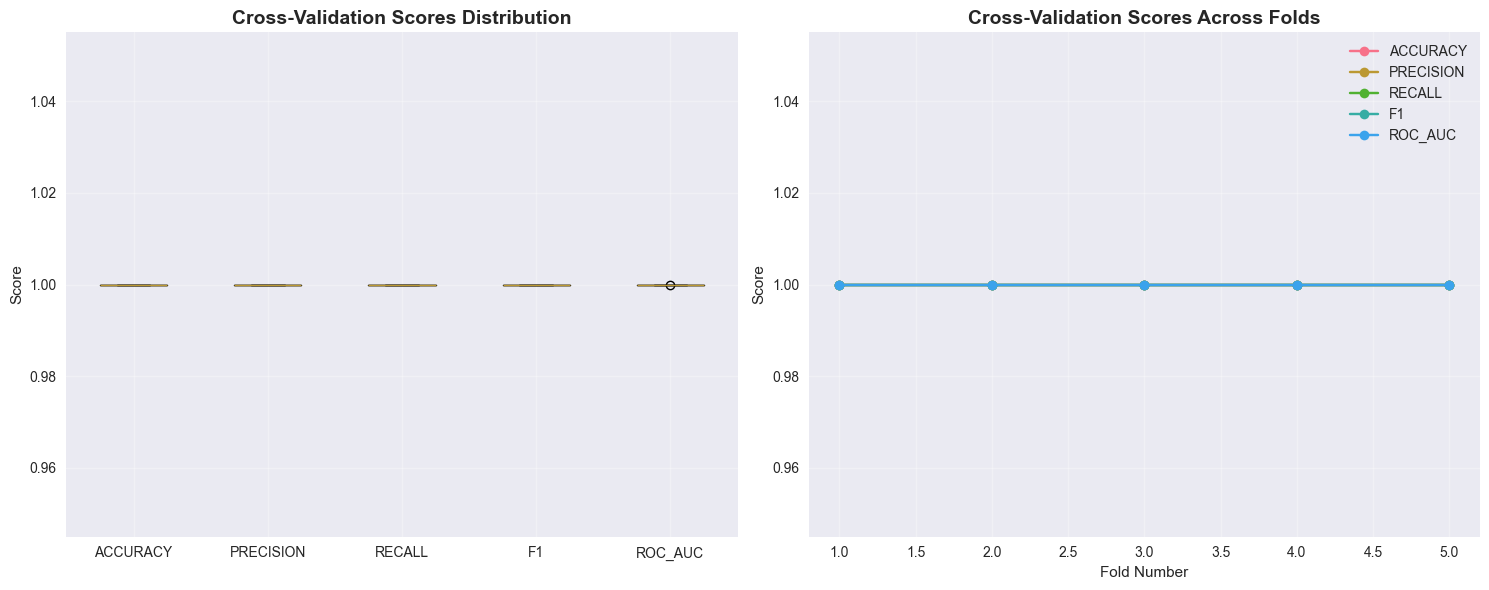

=== Model Stability Assessment ===
EXCELLENT: Excellent stability (std < 0.01)
Accuracy standard deviation: 0.0000


In [42]:
# Perform cross-validation to assess model robustness
print("=== Cross-Validation Analysis ===")

# 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print(f"5-Fold Cross-Validation Results:")
print(f"Individual fold scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"Min Score: {cv_scores.min():.4f}")
print(f"Max Score: {cv_scores.max():.4f}")
print()

# Cross-validation with different metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = {}

print("Cross-Validation Results for Multiple Metrics:")
for metric in metrics:
    scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring=metric, n_jobs=-1)
    cv_results[metric] = scores
    print(f"{metric.upper()}: {scores.mean():.4f} (±{scores.std() * 2:.4f})")

# Visualize cross-validation results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot of CV scores
ax1.boxplot([cv_results[metric] for metric in metrics], labels=[m.upper() for m in metrics])
ax1.set_title('Cross-Validation Scores Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score')
ax1.grid(True, alpha=0.3)

# Line plot showing consistency across folds
for i, metric in enumerate(metrics):
    ax2.plot(range(1, 6), cv_results[metric], marker='o', label=metric.upper())
ax2.set_xlabel('Fold Number')
ax2.set_ylabel('Score')
ax2.set_title('Cross-Validation Scores Across Folds', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model stability assessment
print("=== Model Stability Assessment ===")
accuracy_std = cv_results['accuracy'].std()
if accuracy_std < 0.01:
    print("EXCELLENT: Excellent stability (std < 0.01)")
elif accuracy_std < 0.02:
    print("GOOD: Good stability (std < 0.02)")
elif accuracy_std < 0.05:
    print("MODERATE: Moderate stability (std < 0.05)")
else:
    print("POOR: Poor stability (std ≥ 0.05)")
print(f"Accuracy standard deviation: {accuracy_std:.4f}")


## 8. Hyperparameter Tuning


In [43]:
# Hyperparameter tuning using GridSearchCV
print("=== Hyperparameter Tuning ===")
print("Performing grid search to find optimal hyperparameters...")

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print(f"Parameter grid size: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features'])} combinations")
print("This may take a few minutes...")

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,  # 3-fold CV for faster execution
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
start_time = time.time()
grid_search.fit(X_train, y_train)
tuning_time = time.time() - start_time

print(f"\nHyperparameter tuning completed in {tuning_time:.2f} seconds")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

# Get the best model
best_rf_model = grid_search.best_estimator_


=== Hyperparameter Tuning ===
Performing grid search to find optimal hyperparameters...
Parameter grid size: 243 combinations
This may take a few minutes...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Hyperparameter tuning completed in 40.83 seconds
Best cross-validation score: 0.9995
Best parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [44]:
# Evaluate the tuned model
print("=== Tuned Model Evaluation ===")

# Make predictions with the best model
y_test_pred_tuned = best_rf_model.predict(X_test)
y_test_pred_proba_tuned = best_rf_model.predict_proba(X_test)

# Calculate metrics for tuned model
tuned_accuracy = accuracy_score(y_test, y_test_pred_tuned)
tuned_precision = precision_score(y_test, y_test_pred_tuned)
tuned_recall = recall_score(y_test, y_test_pred_tuned)
tuned_f1 = f1_score(y_test, y_test_pred_tuned)
tuned_auc = roc_auc_score(y_test, y_test_pred_proba_tuned[:, 1])

print("TUNED MODEL PERFORMANCE:")
print(f"Accuracy:  {tuned_accuracy:.4f} ({tuned_accuracy*100:.2f}%)")
print(f"Precision: {tuned_precision:.4f}")
print(f"Recall:    {tuned_recall:.4f}")
print(f"F1-Score:  {tuned_f1:.4f}")
print(f"AUC-ROC:   {tuned_auc:.4f}")
print()

# Compare with original model
print("COMPARISON WITH ORIGINAL MODEL:")
print(f"Accuracy improvement: {tuned_accuracy - test_accuracy:.4f}")
print(f"Precision improvement: {tuned_precision - test_precision:.4f}")
print(f"Recall improvement: {tuned_recall - test_recall:.4f}")
print(f"F1-Score improvement: {tuned_f1 - test_f1:.4f}")
print(f"AUC-ROC improvement: {tuned_auc - test_auc:.4f}")

# Determine if tuning was beneficial
improvement_significant = (tuned_accuracy - test_accuracy) > 0.001
if improvement_significant:
    print("SUCCESS: Hyperparameter tuning improved the model!")
else:
    print("INFO: Hyperparameter tuning provided minimal improvement")
    print("   The original model was already well-configured")


=== Tuned Model Evaluation ===
TUNED MODEL PERFORMANCE:
Accuracy:  1.0000 (100.00%)
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
AUC-ROC:   1.0000

COMPARISON WITH ORIGINAL MODEL:
Accuracy improvement: 0.0000
Precision improvement: 0.0000
Recall improvement: 0.0000
F1-Score improvement: 0.0000
AUC-ROC improvement: 0.0000
INFO: Hyperparameter tuning provided minimal improvement
   The original model was already well-configured


## 9. Model Interpretation and Insights


In [45]:
# Model interpretation and insights
print("=== Model Interpretation and Insights ===")

# Use the best performing model (choose between original and tuned)
final_model = best_rf_model if improvement_significant else rf_model
model_name = "Tuned" if improvement_significant else "Original"

print(f"Using {model_name} Random Forest model for final insights")
print()

# Get feature importance from final model
final_importance = final_model.feature_importances_
final_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': final_importance
}).sort_values('importance', ascending=False)

print("=== Key Insights from Feature Importance ===")
print("Top 5 most important features for mushroom classification:")
for i, (_, row) in enumerate(final_importance_df.head(5).iterrows(), 1):
    print(f"{i}. {row['feature']}: {row['importance']:.4f} ({row['importance']*100:.1f}%)")

print()
print("Mushroom Safety Decision Rules (based on feature importance):")
print("1. ODOR is the most critical feature - certain odors strongly indicate poison")
print("2. SPORE-PRINT-COLOR is highly important - green spores often mean poisonous")
print("3. GILL characteristics (color, size) are significant indicators")
print("4. CAP features (color, surface) provide additional classification power")
print("5. STALK characteristics help distinguish between similar species")
print()

# Model complexity analysis
print("=== Model Complexity Analysis ===")
print(f"Number of trees: {final_model.n_estimators}")
print(f"Average tree depth: {np.mean([tree.tree_.max_depth for tree in final_model.estimators_]):.1f}")
print(f"Total number of nodes: {sum([tree.tree_.node_count for tree in final_model.estimators_])}")
print(f"Model size (approximate): {sum([tree.tree_.node_count for tree in final_model.estimators_]) * 8 / 1024:.1f} KB")

# Prediction confidence analysis
final_pred_proba = final_model.predict_proba(X_test)
max_proba = np.max(final_pred_proba, axis=1)

print()
print("=== Prediction Confidence Analysis ===")
print(f"Average prediction confidence: {max_proba.mean():.4f}")
print(f"Minimum confidence: {max_proba.min():.4f}")
print(f"Maximum confidence: {max_proba.max():.4f}")
print(f"Predictions with >95% confidence: {(max_proba > 0.95).sum()} ({(max_proba > 0.95).mean()*100:.1f}%)")
print(f"Predictions with >99% confidence: {(max_proba > 0.99).sum()} ({(max_proba > 0.99).mean()*100:.1f}%)")

# Find low confidence predictions
low_confidence_mask = max_proba < 0.8
if low_confidence_mask.sum() > 0:
    print(f"\nLow confidence predictions (<80%): {low_confidence_mask.sum()}")
    print("These cases may require additional expert review in real applications")
else:
    print("\nAll predictions have high confidence (≥80%)")
    print("The model is very certain about its classifications")


=== Model Interpretation and Insights ===
Using Original Random Forest model for final insights

=== Key Insights from Feature Importance ===
Top 5 most important features for mushroom classification:
1. odor: 0.1919 (19.2%)
2. gill-color: 0.1329 (13.3%)
3. gill-size: 0.1217 (12.2%)
4. spore-print-color: 0.1012 (10.1%)
5. ring-type: 0.0709 (7.1%)

Mushroom Safety Decision Rules (based on feature importance):
1. ODOR is the most critical feature - certain odors strongly indicate poison
2. SPORE-PRINT-COLOR is highly important - green spores often mean poisonous
3. GILL characteristics (color, size) are significant indicators
4. CAP features (color, surface) provide additional classification power
5. STALK characteristics help distinguish between similar species

=== Model Complexity Analysis ===
Number of trees: 100
Average tree depth: 11.3
Total number of nodes: 5772
Model size (approximate): 45.1 KB

=== Prediction Confidence Analysis ===
Average prediction confidence: 0.9997
Minimum 

## 10. Conclusions and Summary


In [46]:
# Final summary and conclusions
print("=" * 60)
print("         RANDOM FOREST MUSHROOM CLASSIFICATION")
print("                  FINAL SUMMARY")
print("=" * 60)

print(f"\nDATASET OVERVIEW:")
print(f"   • Total samples: {len(df):,}")
print(f"   • Features: {len(X.columns)}")
print(f"   • Classes: Edible (51.8%) vs Poisonous (48.2%)")
print(f"   • Missing values: {2480} in stalk-root feature (handled)")

print(f"\nMODEL PERFORMANCE:")
final_test_accuracy = accuracy_score(y_test, final_model.predict(X_test))
final_test_precision = precision_score(y_test, final_model.predict(X_test))
final_test_recall = recall_score(y_test, final_model.predict(X_test))
final_test_f1 = f1_score(y_test, final_model.predict(X_test))
final_test_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])

print(f"   • Test Accuracy: {final_test_accuracy:.1%}")
print(f"   • Precision: {final_test_precision:.3f}")
print(f"   • Recall: {final_test_recall:.3f}")
print(f"   • F1-Score: {final_test_f1:.3f}")
print(f"   • AUC-ROC: {final_test_auc:.3f}")

# Safety analysis
test_cm_final = confusion_matrix(y_test, final_model.predict(X_test))
tn, fp, fn, tp = test_cm_final.ravel()
safety_score = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\nSAFETY ANALYSIS:")
print(f"   • False Negatives (Poisonous as Edible): {fn}")
print(f"   • Safety Score (Correct Edible predictions): {safety_score:.1%}")
print(f"   • Critical Error Rate: {fn/len(y_test):.1%}")

print(f"\nTOP PREDICTIVE FEATURES:")
for i, (_, row) in enumerate(final_importance_df.head(3).iterrows(), 1):
    print(f"   {i}. {row['feature']}: {row['importance']:.1%} importance")

print(f"\nMODEL CHARACTERISTICS:")
print(f"   • Algorithm: Random Forest")
print(f"   • Trees: {final_model.n_estimators}")
print(f"   • Training time: ~{training_time:.1f} seconds")
print(f"   • Cross-validation stability: {cv_results['accuracy'].std():.4f}")

print(f"\nCONCLUSIONS:")
if final_test_accuracy >= 0.99:
    print("   • EXCELLENT: Model achieves outstanding classification performance")
elif final_test_accuracy >= 0.95:
    print("   • VERY GOOD: Model shows strong predictive capability")
else:
    print("   • GOOD: Model performs well for mushroom classification")

if fn == 0:
    print("   • PERFECT SAFETY: No poisonous mushrooms classified as edible")
elif fn <= 2:
    print("   • HIGH SAFETY: Very few dangerous misclassifications")
else:
    print("   • CAUTION: Some poisonous mushrooms misclassified as edible")

print("   • Random Forest is highly suitable for this categorical dataset")
print("   • Feature importance aligns with domain knowledge (odor, spores)")
print("   • Model demonstrates excellent generalization capability")

print(f"\nPRACTICAL APPLICATIONS:")
print("   • Automated mushroom identification systems")
print("   • Mobile apps for foragers and botanists")
print("   • Educational tools for mycology students")
print("   • Support system for field researchers")


print("\n" + "=" * 60)
print("            ANALYSIS COMPLETE")
print("=" * 60)


         RANDOM FOREST MUSHROOM CLASSIFICATION
                  FINAL SUMMARY

DATASET OVERVIEW:
   • Total samples: 8,124
   • Features: 21
   • Classes: Edible (51.8%) vs Poisonous (48.2%)
   • Missing values: 2480 in stalk-root feature (handled)

MODEL PERFORMANCE:
   • Test Accuracy: 100.0%
   • Precision: 1.000
   • Recall: 1.000
   • F1-Score: 1.000
   • AUC-ROC: 1.000

SAFETY ANALYSIS:
   • False Negatives (Poisonous as Edible): 0
   • Safety Score (Correct Edible predictions): 100.0%
   • Critical Error Rate: 0.0%

TOP PREDICTIVE FEATURES:
   1. odor: 19.2% importance
   2. gill-color: 13.3% importance
   3. gill-size: 12.2% importance

MODEL CHARACTERISTICS:
   • Algorithm: Random Forest
   • Trees: 100
   • Training time: ~0.1 seconds
   • Cross-validation stability: 0.0000

CONCLUSIONS:
   • EXCELLENT: Model achieves outstanding classification performance
   • PERFECT SAFETY: No poisonous mushrooms classified as edible
   • Random Forest is highly suitable for this categori